### Workshop linear models

In [14]:
# Get dataset using wget
!wget http://ps2.railsreactor.net/datasets/medicine/heart_data.cvs -O heart_data.csv -o wget.log

In [15]:
from os import cpu_count

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)

# ML models
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import classification_report, f1_score

import eli5 
from eli5.sklearn import PermutationImportance
# ! pip install eli5

# vizualizing
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import matplotlib.style as style

random_state = 42
n_jobs = max(cpu_count()-1, 1)

In [16]:
heart = pd.read_csv("heart_data.csv")

In [17]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,293.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,297.000000,303.000000
mean,54.416382,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.316498,0.544554
std,9.211220,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.615809,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [18]:
def train_log_regression(x, y,
                         random_state,
                         metric='accuracy',
                         n_splits=5, 
                         ):

    # cross-validation iterator
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    # create Logistic Regression with default params, random_state=42
    lr = LogisticRegression(random_state=42)

    # estimate its f1-score with cross-validation
    scores_lr = cross_val_score(
                                estimator=lr,
                                X=x, 
                                y=y, 
                                scoring=metric,
                                cv=kf,
                                n_jobs=n_jobs
                            ).mean()
    lr.fit(x,y)
    return lr, scores_lr


def get_xy(df, target="target"):
    return df.drop(target, axis=1), df["target"]

In [19]:
X, y = get_xy(heart)

In [20]:
# train_log_regression(X,y, random_state=random_state)

In [21]:
heart.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [22]:
heart.columns = ['age',
                 'sex',
                 'chest_pain_type',
                 'resting_blood_pressure', 
                 'cholesterol',
                 'fasting_blood_sugar',
                 'rest_ecg',
                 'max_heart_rate_achieved',
                 'exercise_induced_angina',
                 'st_depression', 
                 'st_slope', 
                 'num_major_vessels',
                 'thalassemia',
                 'target']

In [28]:
import pandas_profiling

def get_profiling(df, output_name):
    profile = pandas_profiling.ProfileReport(df=df)
    profile.to_file(output_name)

In [29]:
get_profiling(heart, "heart_stat.html")

### Fill NA by median

In [30]:
age_median = heart.age.median()
thalassemia_median = heart.thalassemia.median()

heart.age = heart.age.fillna(age_median)
heart.thalassemia = heart.thalassemia.fillna(thalassemia_median)

In [31]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                        303 non-null float64
sex                        303 non-null int64
chest_pain_type            303 non-null int64
resting_blood_pressure     303 non-null int64
cholesterol                303 non-null int64
fasting_blood_sugar        303 non-null int64
rest_ecg                   303 non-null int64
max_heart_rate_achieved    303 non-null int64
exercise_induced_angina    303 non-null int64
st_depression              303 non-null float64
st_slope                   303 non-null int64
num_major_vessels          303 non-null int64
thalassemia                303 non-null float64
target                     303 non-null int64
dtypes: float64(3), int64(11)
memory usage: 33.2 KB


In [32]:
X, y = get_xy(heart)
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify = y)
base_lr, scores_baseline = train_log_regression(X_train, y_train, random_state=random_state)
print(f"Base logistic regression score on train: {scores_baseline}")
print(f"Base logistic regression score on test: {base_lr.score(X_test, y_test)}")

Base logistic regression score on train: 0.8099489795918368
Base logistic regression score on test: 0.8032786885245902


/home/smaystr/.pyenv/versions/rr_tools/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Rename categorical value for more information

In [33]:
sex = {0: "female", 1: "male"}
heart['sex'] = heart['sex'].map(sex)

chest_type = {0: "typical angina", 1: "atypical angina", 2: "non-anginal pain", 3: "asymptomatic"}
heart['chest_pain_type'] = heart['chest_pain_type'].map(chest_type)

fasting_blood_sugar = {0: "lower than 120mg/ml", 1: "greater than 120mg/ml"}
heart['fasting_blood_sugar'] = heart['fasting_blood_sugar'].map(fasting_blood_sugar)

rest_ecg = {0:"normal", 1:"ST-T wave abnormality", 2:"left ventricular hypertrophy"}
heart['rest_ecg'] = heart['rest_ecg'].map(rest_ecg)

exercise_induced_angina = {0: "no", 1: "yes"}
heart['exercise_induced_angina'] = heart['exercise_induced_angina'].map(exercise_induced_angina)

st_slope = {1: "upsloping", 2: "flat", 3: "downsloping"}
heart['st_slope'] = heart['st_slope'].map(st_slope)

thalassemia = {1: "normal", 2: "fixed defect", 3: "reversable defect"}
heart['thalassemia'] = heart['thalassemia'].map(thalassemia)

In [34]:
heart.sample(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
260,66.0,female,typical angina,178,228,greater than 120mg/ml,ST-T wave abnormality,165,yes,1.0,upsloping,2,reversable defect,0
132,42.0,male,atypical angina,120,295,lower than 120mg/ml,ST-T wave abnormality,162,no,0.0,flat,0,fixed defect,1
67,45.0,female,atypical angina,130,234,lower than 120mg/ml,normal,175,no,0.6,upsloping,0,fixed defect,1
68,44.0,male,atypical angina,120,220,lower than 120mg/ml,ST-T wave abnormality,170,no,0.0,flat,0,fixed defect,1
207,60.0,female,typical angina,150,258,lower than 120mg/ml,normal,157,no,2.6,upsloping,2,reversable defect,0
2,41.0,female,atypical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1
295,63.0,male,typical angina,140,187,lower than 120mg/ml,normal,144,yes,4.0,flat,2,reversable defect,0
56,48.0,male,typical angina,122,222,lower than 120mg/ml,normal,186,no,0.0,flat,0,fixed defect,1
164,38.0,male,non-anginal pain,138,175,lower than 120mg/ml,ST-T wave abnormality,173,no,0.0,flat,4,fixed defect,1
264,54.0,male,typical angina,110,206,lower than 120mg/ml,normal,108,yes,0.0,upsloping,1,fixed defect,0


In [35]:
heart['sex'] = heart['sex'].astype('object')
heart['chest_pain_type'] = heart['chest_pain_type'].astype('object')
heart['fasting_blood_sugar'] = heart['fasting_blood_sugar'].astype('object')
heart['rest_ecg'] = heart['rest_ecg'].astype('object')
heart['exercise_induced_angina'] = heart['exercise_induced_angina'].astype('object')
heart['st_slope'] = heart['st_slope'].astype('object')
heart['thalassemia'] = heart['thalassemia'].astype('object')

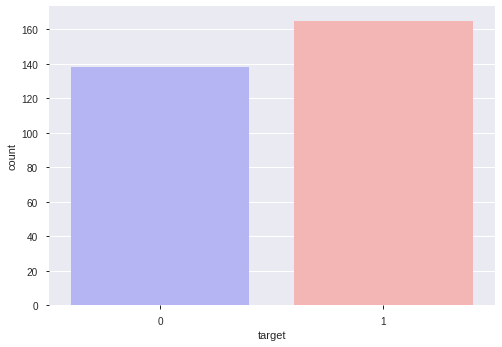

In [36]:
sns.countplot(x="target", data=heart, palette="bwr")
plt.show()

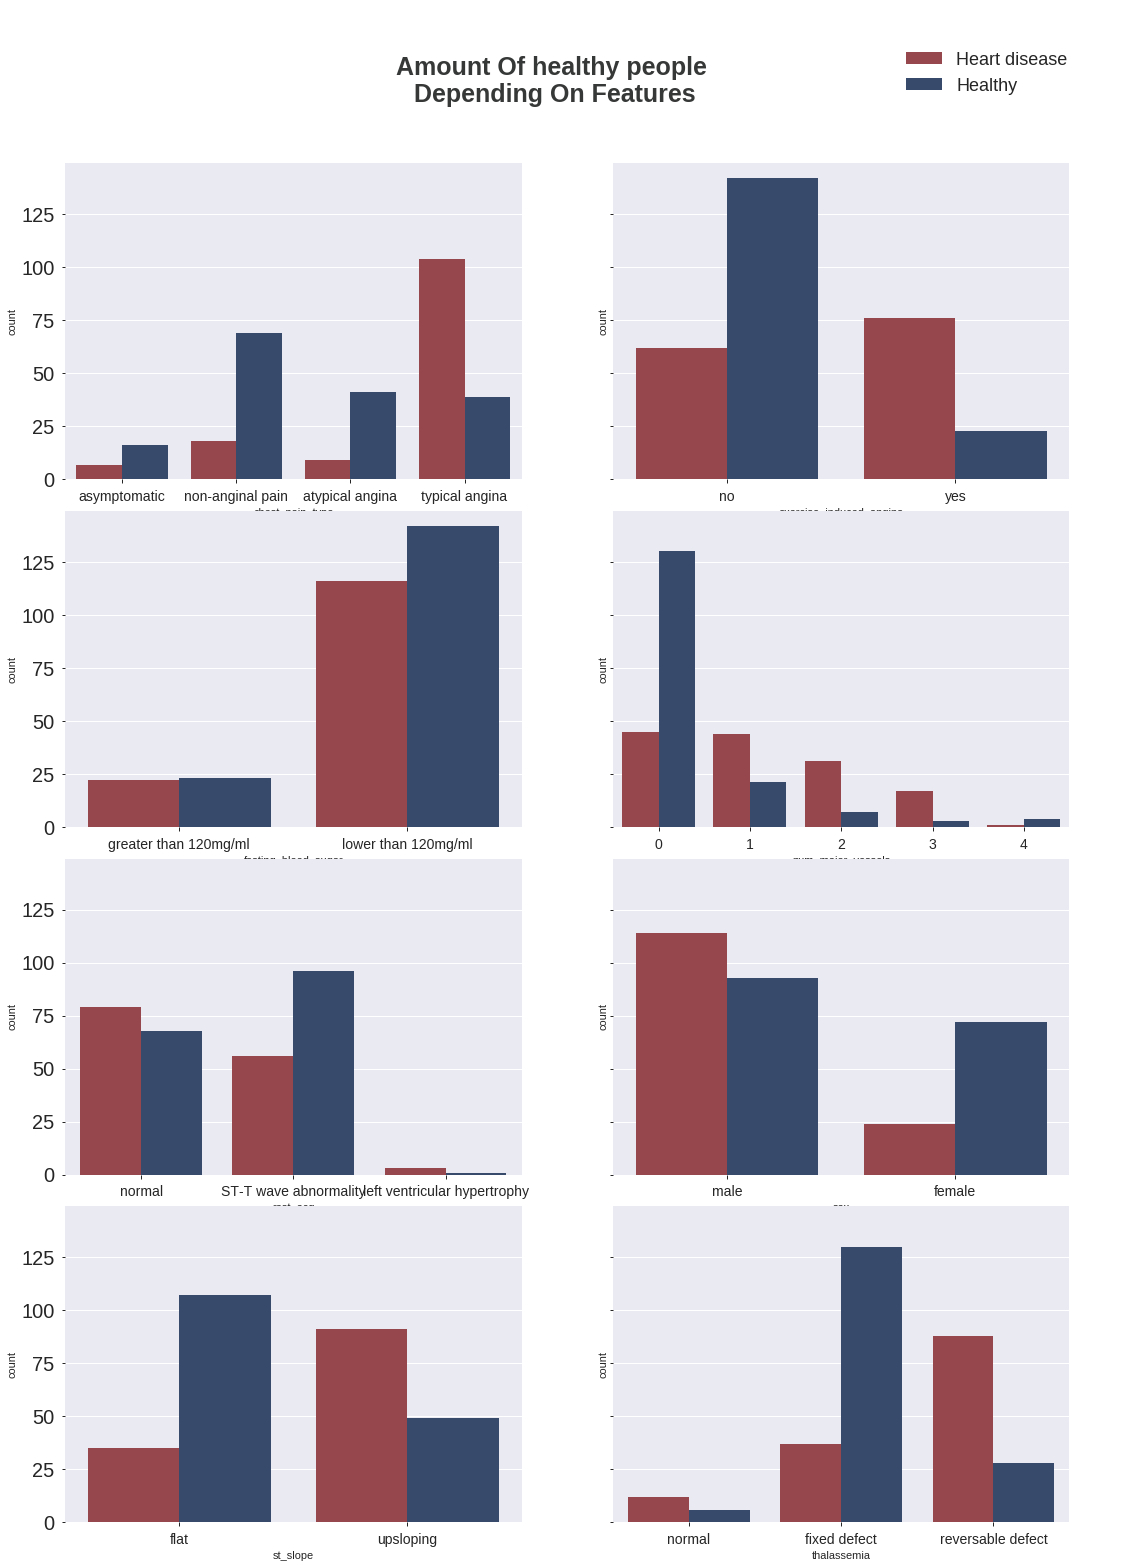

In [37]:
categorical_features = ["chest_pain_type", 
            "exercise_induced_angina",
            "fasting_blood_sugar",
            "num_major_vessels",
            "rest_ecg",
            "sex",
            "st_slope",
            "thalassemia"
           ]

%matplotlib inline 
colors =['#a33a43', '#2e4874'] # custom colors


fig, axes = plt.subplots(4, 2, sharey=True, figsize=(18, 25), gridspec_kw = {'hspace':0.1},)

fig.suptitle("Amount Of healthy people\n Depending On Features",y=.94, fontsize=25, weight = 'bold',color = '#343635',
         alpha = 4)

for i, (col,ax) in enumerate(zip(categorical_features, axes.flatten())):
    #countplot for every feature
    sns.countplot(data=heart, ax=ax, hue='target', x=categorical_features[i], palette=colors)
    
    #customizing every subplot
    ax.tick_params(axis = 'x', which = 'major', labelsize = 14, rotation=0,)
    ax.tick_params(axis = 'y', which = 'major',labelsize = 20)
    ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()
#setting global legend    
fig.legend(handles, ['Heart disease', 'Healthy'], loc=(0.8, 0.935), fontsize = 18, frameon=False)  

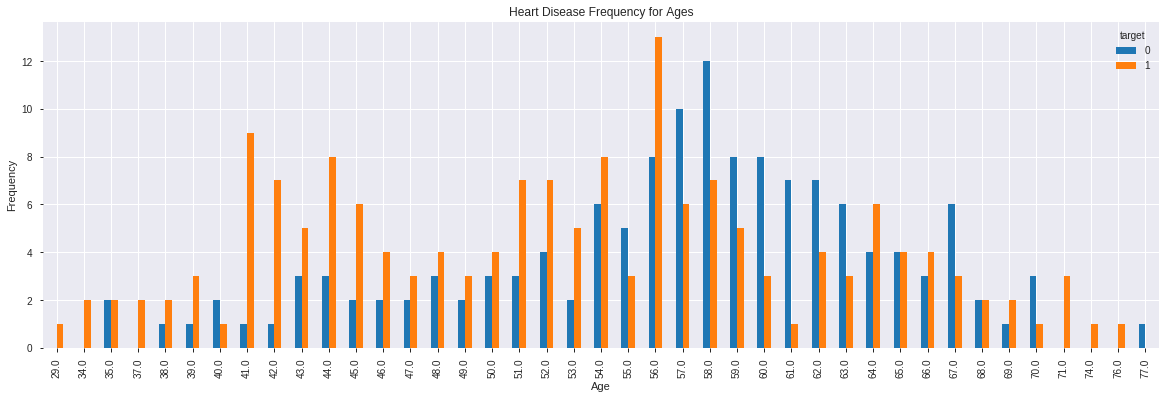

In [38]:
pd.crosstab(heart.age, heart.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

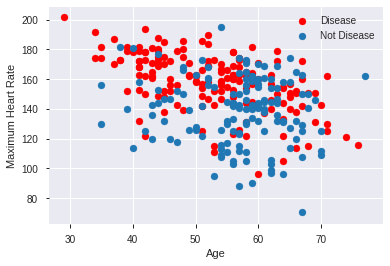

In [39]:
plt.scatter(x=heart.age[heart.target==1], y=heart.max_heart_rate_achieved[(heart.target==1)], c="red")
plt.scatter(x=heart.age[heart.target==0], y=heart.max_heart_rate_achieved[(heart.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()


### OHE categorical values

In [40]:
heart = pd.get_dummies(heart, drop_first=True)
heart.sample(10)

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
18,43.0,150,247,171,1.5,0,1,1,0,0,1,1,0,0,0,0,0,0
190,51.0,130,305,142,1.2,0,0,0,0,0,1,1,0,0,1,1,0,1
64,58.0,140,211,165,0.0,0,1,1,0,1,0,0,0,1,0,0,0,0
245,48.0,124,274,166,0.5,0,0,1,0,0,1,1,0,1,0,1,0,1
210,57.0,128,229,150,0.4,1,0,1,0,1,0,1,0,1,0,1,0,1
154,39.0,138,220,152,0.0,0,1,0,0,1,0,1,0,0,0,1,0,0
67,45.0,130,234,175,0.6,0,1,0,1,0,0,1,0,1,0,1,0,0
112,64.0,140,313,133,0.2,0,1,0,0,1,0,1,0,0,0,0,0,1
253,67.0,100,299,125,0.9,2,0,1,0,0,1,1,0,1,1,1,0,0
167,62.0,140,268,160,3.6,2,0,0,0,0,1,1,0,1,0,0,0,0


In [41]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 18 columns):
age                                        303 non-null float64
resting_blood_pressure                     303 non-null int64
cholesterol                                303 non-null int64
max_heart_rate_achieved                    303 non-null int64
st_depression                              303 non-null float64
num_major_vessels                          303 non-null int64
target                                     303 non-null int64
sex_male                                   303 non-null uint8
chest_pain_type_atypical angina            303 non-null uint8
chest_pain_type_non-anginal pain           303 non-null uint8
chest_pain_type_typical angina             303 non-null uint8
fasting_blood_sugar_lower than 120mg/ml    303 non-null uint8
rest_ecg_left ventricular hypertrophy      303 non-null uint8
rest_ecg_normal                            303 non-null uint8
exercise_induced_angina

### Split data

In [42]:
X, y = get_xy(heart)
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify = y)

In [43]:
log_reg, score = train_log_regression(X_train, y_train, random_state)
print(f"Train logistic regression score with standartization: {score}")
print(f"Test logistic regression score: {log_reg.score(X_test, y_test)}")

Train logistic regression score with standartization: 0.8344387755102041
Test logistic regression score: 0.8360655737704918


/home/smaystr/.pyenv/versions/rr_tools/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
perm = PermutationImportance(log_reg, random_state=random_state).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0521 ± 0.0298,thalassemia_reversable defect
0.0455 ± 0.0228,num_major_vessels
0.0223 ± 0.0170,chest_pain_type_typical angina
0.0116 ± 0.0328,max_heart_rate_achieved
0.0099 ± 0.0124,exercise_induced_angina_yes
0.0058 ± 0.0213,cholesterol
0.0041 ± 0.0148,sex_male
0.0041 ± 0.0091,st_depression
0.0025 ± 0.0040,fasting_blood_sugar_lower than 120mg/ml
0.0017 ± 0.0084,rest_ecg_normal


### Normalize data

In [45]:
numerical_cols = [
    "age",
    "resting_blood_pressure",
]
# X,y= get_xy(heart)

In [56]:
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [47]:
X_train, X_test, y_train, y_test = train_test_split( X, y ,
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify = y)

In [48]:
log_reg, score = train_log_regression(X_train, y_train, random_state)

print(f"Train logistic regression score with standartization: {score}")
print(f"Test logistic regression score with standartization: {log_reg.score(X_test, y_test)}")

Train logistic regression score with standartization: 0.8302721088435373
Test logistic regression score with standartization: 0.8360655737704918


/home/smaystr/.pyenv/versions/rr_tools/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
perm = PermutationImportance(log_reg, random_state=random_state).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0488 ± 0.0274,thalassemia_reversable defect
0.0372 ± 0.0358,num_major_vessels
0.0207 ± 0.0138,chest_pain_type_typical angina
0.0124 ± 0.0091,st_depression
0.0124 ± 0.0188,exercise_induced_angina_yes
0.0107 ± 0.0333,max_heart_rate_achieved
0.0083 ± 0.0105,sex_male
0.0074 ± 0.0033,thalassemia_normal
0.0058 ± 0.0084,fasting_blood_sugar_lower than 120mg/ml
0.0050 ± 0.0110,resting_blood_pressure


### Parameters tuning. Grid search

In [59]:
%%time

params = {'C': [0.1, 0.001, 0.0001, 0.5, 0.9],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'class_weight': ['balanced', None]
    
}

estimator = LogisticRegression(random_state=random_state)
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
    
gs = GridSearchCV(
    estimator=estimator,  
    param_grid=params,  
    cv=kf,  
    error_score=1,  # warnings only
    scoring='accuracy', 
#     scoring='f1',
    n_jobs=n_jobs,
    verbose=1,  
)

gs.fit(
    X=X_train,
    y=y_train
)


best_score = gs.best_score_
best_lr = gs.best_estimator_

print('f1-score best: {:.4f}, +{:.4f} better than baseline'.format(
    best_score, (best_score - scores_baseline))
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 158 tasks      | elapsed:    2.3s


f1-score best: 0.8347, +0.0248 better than baseline
CPU times: user 1.05 s, sys: 16 ms, total: 1.06 s
Wall time: 3.65 s


[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:    3.6s finished
/home/smaystr/.pyenv/versions/rr_tools/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [51]:
print(f"Best logistic regression score: {best_lr.score(X_test, y_test)}")

Best logistic regression score: 0.8688524590163934


### Use [Pipeline](https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/#Using-our-pipeline-in-a-grid-search)

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer


preprocess = make_column_transformer(
    (numerical_cols, StandardScaler()),
    (categorical_features, OneHotEncoder()))

model = make_pipeline(
    preprocess,
    LogisticRegression(C=0.9,
                       solver='lbfgs', random_state=random_state))

/home/smaystr/.pyenv/versions/rr_tools/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:751: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [53]:
def load_data(data_set):
    heart = pd.read_csv(data_set)
    heart.columns = ['age',
                 'sex',
                 'chest_pain_type',
                 'resting_blood_pressure', 
                 'cholesterol',
                 'fasting_blood_sugar',
                 'rest_ecg',
                 'max_heart_rate_achieved',
                 'exercise_induced_angina',
                 'st_depression', 
                 'st_slope', 
                 'num_major_vessels',
                 'thalassemia',
                 'target']
    
    age_median = heart.age.median()
    thalassemia_median = heart.thalassemia.median()

    heart.age = heart.age.fillna(age_median)
    heart.thalassemia = heart.thalassemia.fillna(thalassemia_median)
    return get_xy(heart)
    

In [54]:
X, y = load_data("heart_data.csv")
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.2, 
                                                    random_state=random_state,
                                                    stratify = y)

In [55]:
model.fit(X_train, y_train)
print(f"logistic regression score: {model.score(X_train, y_train)}")
print(f"logistic regression score: {model.score(X_test, y_test)}")

/home/smaystr/.pyenv/versions/rr_tools/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


logistic regression score: 0.871900826446281
logistic regression score: 0.8524590163934426
